# 🐾 PawMI - Análisis de Datasets y PyCaret
## Selección de dataset y algoritmo para el chat de salud

**Objetivo:** Usar PyCaret para probar múltiples algoritmos con un subset pequeño de datos y seleccionar el mejor para entrenar manualmente después.

## 1️⃣ Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys, os, subprocess

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print('Librerías importadas')
print('Python executable:', sys.executable)
print('Virtual env (VIRTUAL_ENV):', os.environ.get('VIRTUAL_ENV'))
print('sys.prefix:', sys.prefix)

Librerías importadas
Python executable: c:\Users\julia\Dropbox\My PC (LAPTOP-LKGFJOOJ)\Downloads\petcare\.venv-py311\Scripts\python.exe
Virtual env (VIRTUAL_ENV): C:\Users\julia\Dropbox\My PC (LAPTOP-LKGFJOOJ)\Downloads\petcare\.venv-py311
sys.prefix: c:\Users\julia\Dropbox\My PC (LAPTOP-LKGFJOOJ)\Downloads\petcare\.venv-py311


## 📦 Dataset Realista - Veterinario

**Dataset:** `vet_realistic_dataset.csv` - Datos veterinarios de perros y gatos con enfermedades y síntomas clínicos.

In [2]:
# Cargar dataset veterinario realista
data_path = Path('../data/raw')
df = pd.read_csv(data_path / 'vet_dataset_improved_lownoise.csv')

print('✅ Dataset veterinario cargado')
print(f'Shape: {df.shape}')
print(f'\n📋 Columnas:')
print(df.columns.tolist())
print(f'\n👁️ Primeras 3 filas:')
display(df.head(3))
print(f'\n🐾 Distribución de especies (animal_type):')
print(df['animal_type'].value_counts())
print(f'\n🏥 Distribución de enfermedades (disease):')
print(df['disease'].value_counts())
print(f'\n📊 Estadísticas básicas:')
print(f'   Total registros: {len(df)}')
print(f'   Enfermedades únicas: {df["disease"].nunique()}')
print(f'   Razas únicas: {df["breed"].nunique()}')

✅ Dataset veterinario cargado
Shape: (2400, 57)

📋 Columnas:
['animal_type', 'breed', 'age', 'size', 'life_stage', 'weight_kg', 'sex', 'vaccination_up_to_date', 'duration_acute', 'duration_subacute', 'duration_chronic', 'exposure_mosquitos', 'contact_other_animals', 'disease', 'fever', 'vomiting', 'diarrhea', 'diarrhea_hemorrhagic', 'loss_appetite', 'lethargy', 'dehydration', 'abdominal_pain', 'cough', 'nasal_discharge', 'ocular_discharge', 'sneezing', 'salivation', 'mouth_ulcers', 'conjunctivitis', 'breathing_difficulty', 'tachypnea', 'weight_loss', 'increased_thirst', 'increased_urination', 'increased_appetite', 'seizures', 'convulsions', 'neurologic_signs', 'alopecia', 'itching', 'skin_crusts', 'thickened_skin', 'ear_discharge', 'ear_odor', 'head_shaking', 'limping', 'stiff_gait', 'difficulty_rising', 'reluctance_to_jump', 'joint_pain', 'hyperactivity', 'unkempt_coat', 'wheezing', 'open_mouth_breathing', 'dry_cough', 'exercise_intolerance', 'painful_belly']

👁️ Primeras 3 filas:


,animal_type,breed,age,size,life_stage,weight_kg,sex,vaccination_up_to_date,duration_acute,duration_subacute,...,difficulty_rising,reluctance_to_jump,joint_pain,hyperactivity,unkempt_coat,wheezing,open_mouth_breathing,dry_cough,exercise_intolerance,painful_belly
0,Perro,Beagle,8.8,Large,Senior,29.0,Female,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Gato,Siamese,13.9,Small,Senior,3.1,Female,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Perro,Pug,11.5,Small,Senior,7.5,Female,1,0,1,...,0,0,0,0,1,0,0,0,0,0



🐾 Distribución de especies (animal_type):
animal_type
Perro    1500
Gato      900
Name: count, dtype: int64

🏥 Distribución de enfermedades (disease):
disease
Sarna demodécica                          150
Diabetes mellitus (gato)                  150
Hipertiroidismo (gato)                    150
Moquillo (distemper)                      150
Insuficiencia renal crónica (perro)       150
Parvovirosis                              150
Insuficiencia renal crónica (gato)        150
Panleucopenia felina                      150
Artritis                                  150
Gastroenteritis aguda                     150
Diabetes mellitus (perro)                 150
Complejo respiratorio felino (FVR/FCV)    150
Alergias cutáneas                         150
Asma felina                               150
Otitis externa                            150
Dirofilariosis                            150
Name: count, dtype: int64

📊 Estadísticas básicas:
   Total registros: 2400
   Enfermedades únicas: 16
 

### 🧹 Limpieza y Preprocesamiento del Dataset

In [3]:
print('🔍 Analizando calidad de datos...')

# 1. Ver valores nulos
print(f'\n📊 Valores nulos por columna:')
null_counts = df.isnull().sum()
if null_counts.sum() > 0:
    print(null_counts[null_counts > 0])
else:
    print('   ✅ ¡No hay valores nulos!')

# 2. Ver duplicados
duplicates = df.duplicated().sum()
print(f'\n📊 Duplicados: {duplicates}')

# 3. Tipos de datos
print(f'\n📊 Tipos de datos:')
print(df.dtypes.value_counts())

# 4. Info del dataset
print(f'\n📊 Info general:')
print(f'   Shape: {df.shape}')
print(f'   Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# 5. Características numéricas vs binarias
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'\n📊 Columnas numéricas ({len(numeric_cols)}): {numeric_cols[:5]}...')

# 6. Muestra de datos
print(f'\n👁️ Muestra de datos:')
display(df.head())

🔍 Analizando calidad de datos...

📊 Valores nulos por columna:
   ✅ ¡No hay valores nulos!

📊 Duplicados: 0

📊 Tipos de datos:
int64      49
object      6
float64     2
Name: count, dtype: int64

📊 Info general:
   Shape: (2400, 57)
   Memoria: 1.86 MB

📊 Columnas numéricas (51): ['age', 'weight_kg', 'vaccination_up_to_date', 'duration_acute', 'duration_subacute']...

👁️ Muestra de datos:
   Memoria: 1.86 MB

📊 Columnas numéricas (51): ['age', 'weight_kg', 'vaccination_up_to_date', 'duration_acute', 'duration_subacute']...

👁️ Muestra de datos:


,animal_type,breed,age,size,life_stage,weight_kg,sex,vaccination_up_to_date,duration_acute,duration_subacute,...,difficulty_rising,reluctance_to_jump,joint_pain,hyperactivity,unkempt_coat,wheezing,open_mouth_breathing,dry_cough,exercise_intolerance,painful_belly
0,Perro,Beagle,8.8,Large,Senior,29.0,Female,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Gato,Siamese,13.9,Small,Senior,3.1,Female,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Perro,Pug,11.5,Small,Senior,7.5,Female,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,Gato,Bengal,10.3,Small,Senior,5.1,Male,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Perro,Golden Retriever,5.5,Small,Adult,10.5,Female,0,0,1,...,1,0,0,0,0,0,0,1,1,0


### 🎯 Preparación de Datos para Machine Learning

In [4]:
# Seleccionar features relevantes para ML (todos los síntomas binarios)
# Excluir columnas descriptivas: breed (muchas categorías)

features_ml = [
    # Demografía básica
    'animal_type', 'age', 'size', 'life_stage', 'weight_kg', 'sex', 'vaccination_up_to_date',
    
    # Síntomas clínicos (binarios 0/1)
    'fever', 'vomiting', 'diarrhea', 'diarrhea_hemorrhagic', 'loss_appetite', 'lethargy',
    'dehydration', 'abdominal_pain', 'cough', 'nasal_discharge', 'ocular_discharge',
    'sneezing', 'salivation', 'mouth_ulcers', 'conjunctivitis', 'breathing_difficulty',
    'tachypnea', 'weight_loss', 'increased_thirst', 'increased_urination', 'increased_appetite',
    'seizures', 'convulsions', 'neurologic_signs', 'alopecia', 'itching', 'skin_crusts',
    'thickened_skin', 'ear_discharge', 'ear_odor', 'head_shaking', 'limping', 'stiff_gait',
    'difficulty_rising', 'reluctance_to_jump', 'joint_pain', 'hyperactivity', 'unkempt_coat',
    'wheezing', 'open_mouth_breathing', 'dry_cough', 'exercise_intolerance', 'painful_belly',
    
    # Target
    'disease'
]

# Crear dataset ML
df_ml = df[features_ml].copy()

# Eliminar filas con NaN (si hay alguna)
df_ml = df_ml.dropna()

print('✅ Dataset ML preparado')
print(f'\n📊 Información:')
print(f'   Registros: {df_ml.shape[0]}')
print(f'   Features: {df_ml.shape[1] - 1} (+ 1 target)')
print(f'   Enfermedades: {df_ml["disease"].nunique()}')

print(f'\n🏥 Distribución de enfermedades:')
disease_dist = df_ml['disease'].value_counts()
print(disease_dist)

print(f'\n🐾 Distribución Animal Type:')
print(df_ml['animal_type'].value_counts())

print(f'\n📋 Total de columnas: {len(df_ml.columns)}')

✅ Dataset ML preparado

📊 Información:
   Registros: 2400
   Features: 50 (+ 1 target)
   Enfermedades: 16

🏥 Distribución de enfermedades:
disease
Sarna demodécica                          150
Diabetes mellitus (gato)                  150
Hipertiroidismo (gato)                    150
Moquillo (distemper)                      150
Insuficiencia renal crónica (perro)       150
Parvovirosis                              150
Insuficiencia renal crónica (gato)        150
Panleucopenia felina                      150
Artritis                                  150
Gastroenteritis aguda                     150
Diabetes mellitus (perro)                 150
Complejo respiratorio felino (FVR/FCV)    150
Alergias cutáneas                         150
Asma felina                               150
Otitis externa                            150
Dirofilariosis                            150
Name: count, dtype: int64

🐾 Distribución Animal Type:
animal_type
Perro    1500
Gato      900
Name: count, dtype: i

## 🤖 Comparación Rápida con PyCaret

Usaremos una **muestra pequeña** (10-15% del dataset) para probar múltiples algoritmos rápidamente con PyCaret.

In [5]:
from sklearn.model_selection import train_test_split

print('📊 Preparando muestra para PyCaret...')

# Tomar muestra estratificada (15% del dataset)
df_sample, _ = train_test_split(
    df_ml, 
    test_size=0.85,
    stratify=df_ml['disease'],
    random_state=42
)

print(f'✅ Muestra creada: {df_sample.shape}')
print(f'\n🏥 Distribución de enfermedades en la muestra:')
print(df_sample['disease'].value_counts())

print(f'\n📌 Esta muestra se usará para comparación rápida con PyCaret')
print(f'📌 Después entrenaremos manualmente con el dataset completo')

📊 Preparando muestra para PyCaret...
✅ Muestra creada: (360, 51)

🏥 Distribución de enfermedades en la muestra:
disease
Panleucopenia felina                      23
Insuficiencia renal crónica (gato)        23
Diabetes mellitus (perro)                 23
Hipertiroidismo (gato)                    23
Artritis                                  23
Alergias cutáneas                         23
Parvovirosis                              23
Moquillo (distemper)                      23
Insuficiencia renal crónica (perro)       22
Diabetes mellitus (gato)                  22
Dirofilariosis                            22
Otitis externa                            22
Gastroenteritis aguda                     22
Asma felina                               22
Complejo respiratorio felino (FVR/FCV)    22
Sarna demodécica                          22
Name: count, dtype: int64

📌 Esta muestra se usará para comparación rápida con PyCaret
📌 Después entrenaremos manualmente con el dataset completo


### ? Setup de PyCaret y Comparación de Modelos

In [6]:
# Intentar usar PyCaret para comparación rápida
try:
    from pycaret.classification import setup, compare_models, pull
    
    print('🚀 Configurando PyCaret...')
    
    # Setup de PyCaret
    clf_setup = setup(
        data=df_sample,
        target='disease',
        session_id=42,
        verbose=False,
        normalize=True,
        categorical_features=['animal_type', 'size', 'life_stage', 'sex', 'vaccination_up_to_date']
    )
    
    print('\n✅ Setup completado')
    print('\n📊 Comparando modelos (top 5)...')
    
    # Comparar modelos (solo top 5 para ser rápido)
    best_models = compare_models(n_select=5, turbo=True)
    
    print('\n🏆 Mejores modelos encontrados')
    results = pull()
    display(results)
    
except ImportError:
    print('⚠️  PyCaret no está instalado o tiene problemas de compatibilidad')
    print('📌 Saltando comparación con PyCaret')
    print('📌 Procederemos directamente al entrenamiento manual con Scikit-Learn')
except Exception as e:
    print(f'⚠️  Error en PyCaret: {e}')
    print('📌 Procederemos con entrenamiento manual con Scikit-Learn')

🚀 Configurando PyCaret...

✅ Setup completado

📊 Comparando modelos (top 5)...

✅ Setup completado

📊 Comparando modelos (top 5)...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.0917,0.0000,0.0917,0.0763,0.0782,0.0322,0.0331,0.1120
lda,Linear Discriminant Analysis,0.0837,0.0000,0.0837,0.0687,0.0701,0.0235,0.0241,0.1980
catboost,CatBoost Classifier,0.0797,0.5163,0.0797,0.0812,0.0751,0.0208,0.0212,46.8150
et,Extra Trees Classifier,0.0718,0.4991,0.0718,0.0731,0.0650,0.0113,0.0117,0.4440
lr,Logistic Regression,0.0677,0.0000,0.0677,0.0524,0.0562,0.0057,0.0058,3.3190
qda,Quadratic Discriminant Analysis,0.0675,0.0000,0.0675,0.0621,0.0594,0.0058,0.0059,0.1440
svm,SVM - Linear Kernel,0.0595,0.0000,0.0595,0.0489,0.0503,-0.0028,-0.0028,0.1330
dt,Decision Tree Classifier,0.0558,0.4960,0.0558,0.0557,0.0519,-0.0080,-0.0080,0.1260
rf,Random Forest Classifier,0.0558,0.5077,0.0558,0.0549,0.0492,-0.0047,-0.0048,0.3860
ada,Ada Boost Classifier,0.0520,0.0000,0.0520,0.0383,0.0401,-0.0097,-0.0105,0.2110



🏆 Mejores modelos encontrados


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.0917,0.0000,0.0917,0.0763,0.0782,0.0322,0.0331,0.112
lda,Linear Discriminant Analysis,0.0837,0.0000,0.0837,0.0687,0.0701,0.0235,0.0241,0.198
catboost,CatBoost Classifier,0.0797,0.5163,0.0797,0.0812,0.0751,0.0208,0.0212,46.815
et,Extra Trees Classifier,0.0718,0.4991,0.0718,0.0731,0.0650,0.0113,0.0117,0.444
lr,Logistic Regression,0.0677,0.0000,0.0677,0.0524,0.0562,0.0057,0.0058,3.319
qda,Quadratic Discriminant Analysis,0.0675,0.0000,0.0675,0.0621,0.0594,0.0058,0.0059,0.144
svm,SVM - Linear Kernel,0.0595,0.0000,0.0595,0.0489,0.0503,-0.0028,-0.0028,0.133
dt,Decision Tree Classifier,0.0558,0.4960,0.0558,0.0557,0.0519,-0.0080,-0.0080,0.126
rf,Random Forest Classifier,0.0558,0.5077,0.0558,0.0549,0.0492,-0.0047,-0.0048,0.386
ada,Ada Boost Classifier,0.0520,0.0000,0.0520,0.0383,0.0401,-0.0097,-0.0105,0.211


## 🔧 Entrenamiento Manual con Dataset Completo

Ahora entrenaremos con **TODO el dataset** usando Scikit-Learn para comparar múltiples algoritmos.

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print('🔧 Preparando datos para entrenamiento con dataset completo...')

# Separar features y target
X = df_ml.drop('disease', axis=1)
y = df_ml['disease']

# Codificar variables categóricas
le_animal = LabelEncoder()
le_size = LabelEncoder()
le_life = LabelEncoder()
le_sex = LabelEncoder()
le_vacc = LabelEncoder()

X_processed = X.copy()
X_processed['animal_type'] = le_animal.fit_transform(X['animal_type'])
X_processed['size'] = le_size.fit_transform(X['size'])
X_processed['life_stage'] = le_life.fit_transform(X['life_stage'])
X_processed['sex'] = le_sex.fit_transform(X['sex'])
X_processed['vaccination_up_to_date'] = le_vacc.fit_transform(X['vaccination_up_to_date'])

# Normalizar features numéricas
scaler = StandardScaler()
numeric_features = ['age', 'weight_kg']
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])

print(f'✅ Datos preprocesados:')
print(f'   Features shape: {X_processed.shape}')
print(f'   Target shape: {y.shape}')
print(f'   Clases únicas: {y.nunique()}')

# Split train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f'\n📊 Split de datos:')
print(f'   Train: {X_train.shape[0]} registros ({X_train.shape[0]/len(X_processed)*100:.1f}%)')
print(f'   Test:  {X_test.shape[0]} registros ({X_test.shape[0]/len(X_processed)*100:.1f}%)')

# Definir algoritmos a probar
algorithms = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    'SVM (RBF)': SVC(random_state=42, kernel='rbf'),
    'K-Neighbors (k=5)': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=15)
}

print(f'\n✅ Listos para entrenar {len(algorithms)} algoritmos con {X_train.shape[0]} registros')

🔧 Preparando datos para entrenamiento con dataset completo...
✅ Datos preprocesados:
   Features shape: (2400, 50)
   Target shape: (2400,)
   Clases únicas: 16

📊 Split de datos:
   Train: 1680 registros (70.0%)
   Test:  720 registros (30.0%)

✅ Listos para entrenar 7 algoritmos con 1680 registros


### 🔬 Análisis de Correlación entre Síntomas y Enfermedades

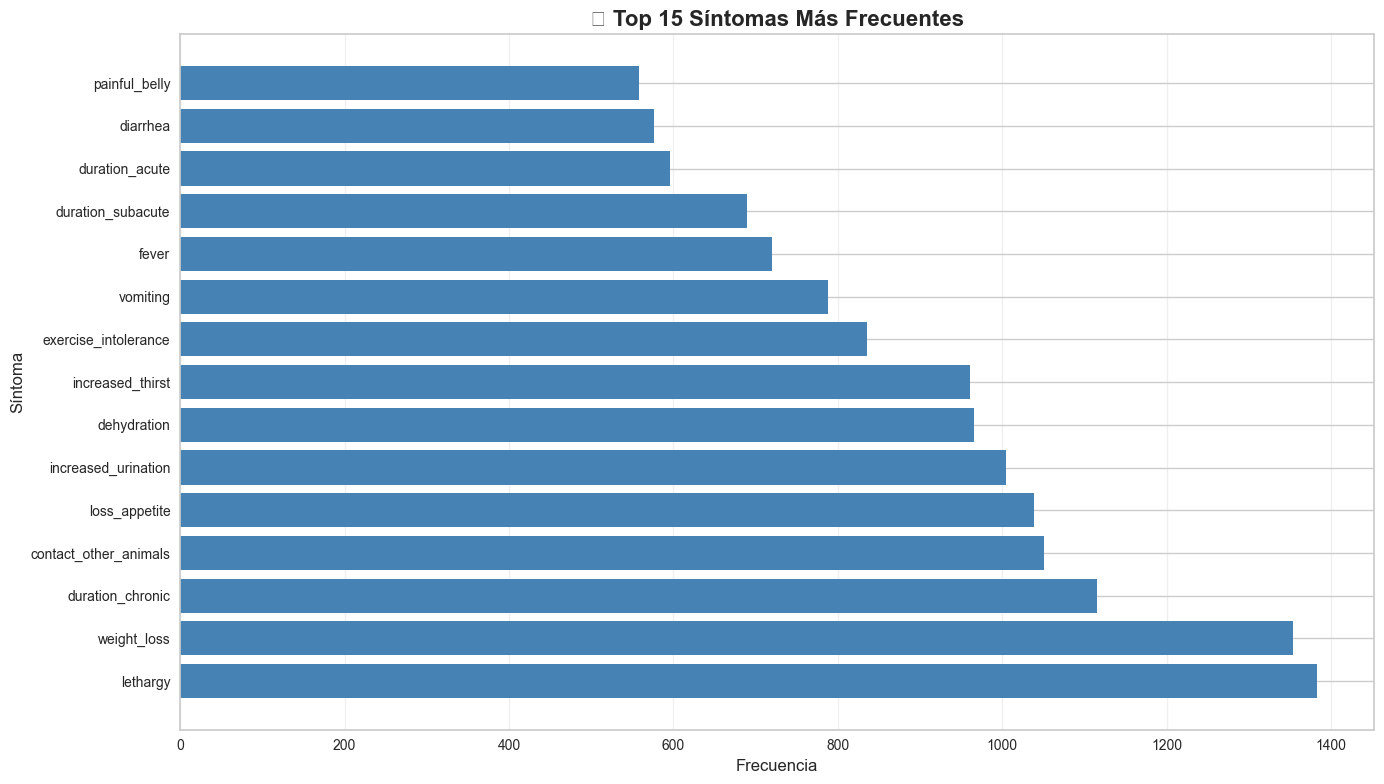

🩺 Top 10 síntomas más frecuentes:
    1. lethargy                      : 1383 casos (57.6%)
    2. weight_loss                   : 1354 casos (56.4%)
    3. duration_chronic              : 1115 casos (46.5%)
    4. contact_other_animals         : 1051 casos (43.8%)
    5. loss_appetite                 : 1038 casos (43.2%)
    6. increased_urination           : 1004 casos (41.8%)
    7. dehydration                   :  966 casos (40.2%)
    8. increased_thirst              :  961 casos (40.0%)
    9. exercise_intolerance          :  836 casos (34.8%)
   10. vomiting                      :  788 casos (32.8%)

📊 Total de síntomas/features binarios: 48


In [8]:
# Análisis de síntomas más comunes
# Obtener todas las columnas de síntomas (binarias 0/1)
symptom_cols = [col for col in df.columns if col not in ['animal_type', 'breed', 'age', 'size', 
                                                           'life_stage', 'weight_kg', 'sex', 
                                                           'vaccination_up_to_date', 'disease']]

# Calcular frecuencia de cada síntoma
symptom_freq = {}
for col in symptom_cols:
    symptom_freq[col] = df[col].sum()

# Ordenar por frecuencia
symptom_freq_sorted = dict(sorted(symptom_freq.items(), key=lambda x: x[1], reverse=True))

# Visualizar top 15 síntomas
plt.figure(figsize=(14, 8))
top_15_symptoms = dict(list(symptom_freq_sorted.items())[:15])
plt.barh(list(top_15_symptoms.keys()), list(top_15_symptoms.values()), color='steelblue')
plt.xlabel('Frecuencia', fontsize=12)
plt.ylabel('Síntoma', fontsize=12)
plt.title('🩺 Top 15 Síntomas Más Frecuentes', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print('🩺 Top 10 síntomas más frecuentes:')
for i, (symptom, freq) in enumerate(list(symptom_freq_sorted.items())[:10], 1):
    print(f'   {i:2d}. {symptom:30s}: {freq:4d} casos ({freq/len(df)*100:.1f}%)')

print(f'\n📊 Total de síntomas/features binarios: {len(symptom_cols)}')

In [9]:
# Analizar síntomas más comunes por enfermedad (top 3 enfermedades)
top_diseases = df['disease'].value_counts().head(3).index

print('🔬 Síntomas característicos de las 3 enfermedades más frecuentes:\n')

for disease in top_diseases:
    print(f'\n{"="*60}')
    print(f'🏥 {disease}')
    print(f'{"="*60}')
    
    # Filtrar casos de esta enfermedad
    disease_df = df[df['disease'] == disease]
    
    # Calcular frecuencia de síntomas para esta enfermedad
    disease_symptoms = {}
    for col in symptom_cols:
        freq = disease_df[col].sum()
        percentage = (freq / len(disease_df)) * 100
        if percentage > 20:  # Solo mostrar síntomas que aparecen en >20% de los casos
            disease_symptoms[col] = percentage
    
    # Ordenar y mostrar
    disease_symptoms_sorted = dict(sorted(disease_symptoms.items(), key=lambda x: x[1], reverse=True))
    
    print(f'\nSíntomas presentes en más del 20% de los casos:')
    for symptom, percentage in list(disease_symptoms_sorted.items())[:10]:
        bar = '█' * int(percentage / 5)
        print(f'   {symptom:30s}: {bar:20s} {percentage:.1f}%')
    
    print(f'\nTotal de casos: {len(disease_df)}')

🔬 Síntomas característicos de las 3 enfermedades más frecuentes:


🏥 Sarna demodécica

Síntomas presentes en más del 20% de los casos:
   alopecia                      : ██████████████████   94.0%
   itching                       : ████████████████     82.0%
   skin_crusts                   : ████████████████     80.0%
   duration_chronic              : █████████████        65.3%
   thickened_skin                : ██████████           50.0%
   weight_loss                   : ████████             40.7%
   unkempt_coat                  : ███████              37.3%
   duration_subacute             : █████                29.3%
   increased_thirst              : ████                 20.7%

Total de casos: 150

🏥 Diabetes mellitus (gato)

Síntomas presentes en más del 20% de los casos:
   weight_loss                   : ███████████████      78.7%
   increased_urination           : ███████████████      78.7%
   increased_thirst              : ███████████████      76.7%
   duration_chronic    

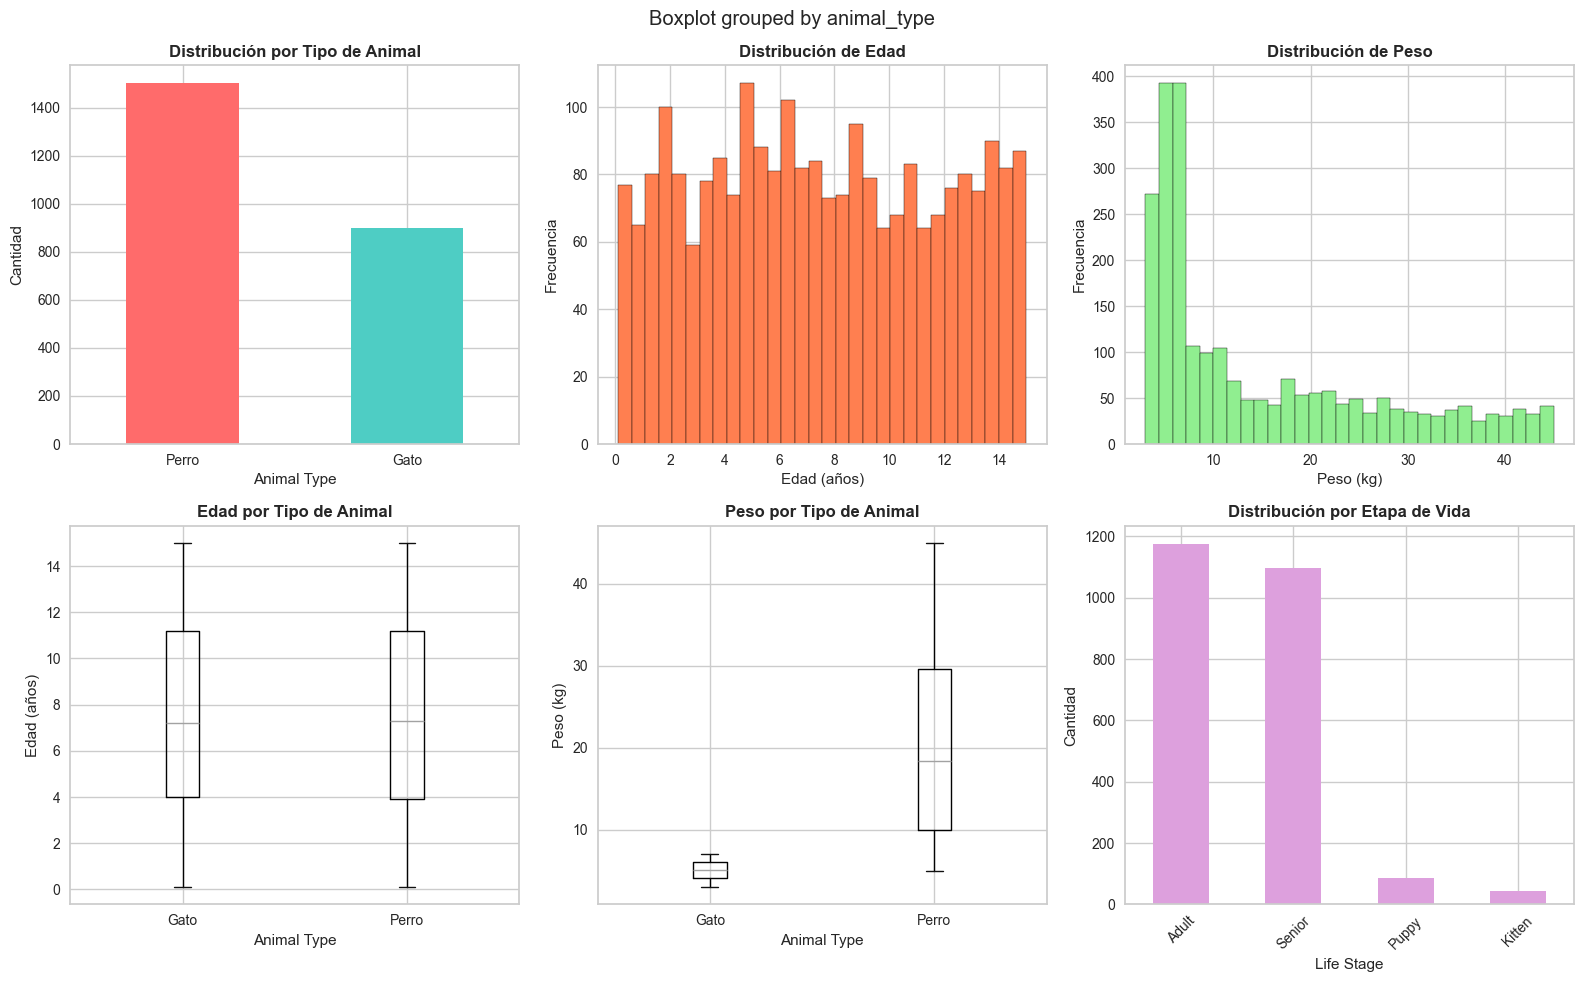

📊 Estadísticas demográficas:

Edad promedio: 7.51 años (±4.31)
Peso promedio: 14.80 kg (±11.95)

Distribución por sexo:
sex
Male      1204
Female    1196
Name: count, dtype: int64

Vacunación al día:
vaccination_up_to_date
1    1285
0    1115
Name: count, dtype: int64


In [10]:
# Análisis de características demográficas
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Distribución por tipo de animal
df['animal_type'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#FF6B6B', '#4ECDC4'])
axes[0,0].set_title('Distribución por Tipo de Animal', fontweight='bold')
axes[0,0].set_xlabel('Animal Type')
axes[0,0].set_ylabel('Cantidad')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Distribución de edad
df['age'].hist(bins=30, ax=axes[0,1], color='coral', edgecolor='black')
axes[0,1].set_title('Distribución de Edad', fontweight='bold')
axes[0,1].set_xlabel('Edad (años)')
axes[0,1].set_ylabel('Frecuencia')

# 3. Distribución de peso
df['weight_kg'].hist(bins=30, ax=axes[0,2], color='lightgreen', edgecolor='black')
axes[0,2].set_title('Distribución de Peso', fontweight='bold')
axes[0,2].set_xlabel('Peso (kg)')
axes[0,2].set_ylabel('Frecuencia')

# 4. Edad vs Tipo de Animal
df.boxplot(column='age', by='animal_type', ax=axes[1,0])
axes[1,0].set_title('Edad por Tipo de Animal', fontweight='bold')
axes[1,0].set_xlabel('Animal Type')
axes[1,0].set_ylabel('Edad (años)')
plt.sca(axes[1,0])
plt.xticks(rotation=0)

# 5. Peso vs Tipo de Animal
df.boxplot(column='weight_kg', by='animal_type', ax=axes[1,1])
axes[1,1].set_title('Peso por Tipo de Animal', fontweight='bold')
axes[1,1].set_xlabel('Animal Type')
axes[1,1].set_ylabel('Peso (kg)')
plt.sca(axes[1,1])
plt.xticks(rotation=0)

# 6. Distribución por etapa de vida
df['life_stage'].value_counts().plot(kind='bar', ax=axes[1,2], color='plum')
axes[1,2].set_title('Distribución por Etapa de Vida', fontweight='bold')
axes[1,2].set_xlabel('Life Stage')
axes[1,2].set_ylabel('Cantidad')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print('📊 Estadísticas demográficas:')
print(f'\nEdad promedio: {df["age"].mean():.2f} años (±{df["age"].std():.2f})')
print(f'Peso promedio: {df["weight_kg"].mean():.2f} kg (±{df["weight_kg"].std():.2f})')
print(f'\nDistribución por sexo:')
print(df['sex'].value_counts())
print(f'\nVacunación al día:')
print(df['vaccination_up_to_date'].value_counts())

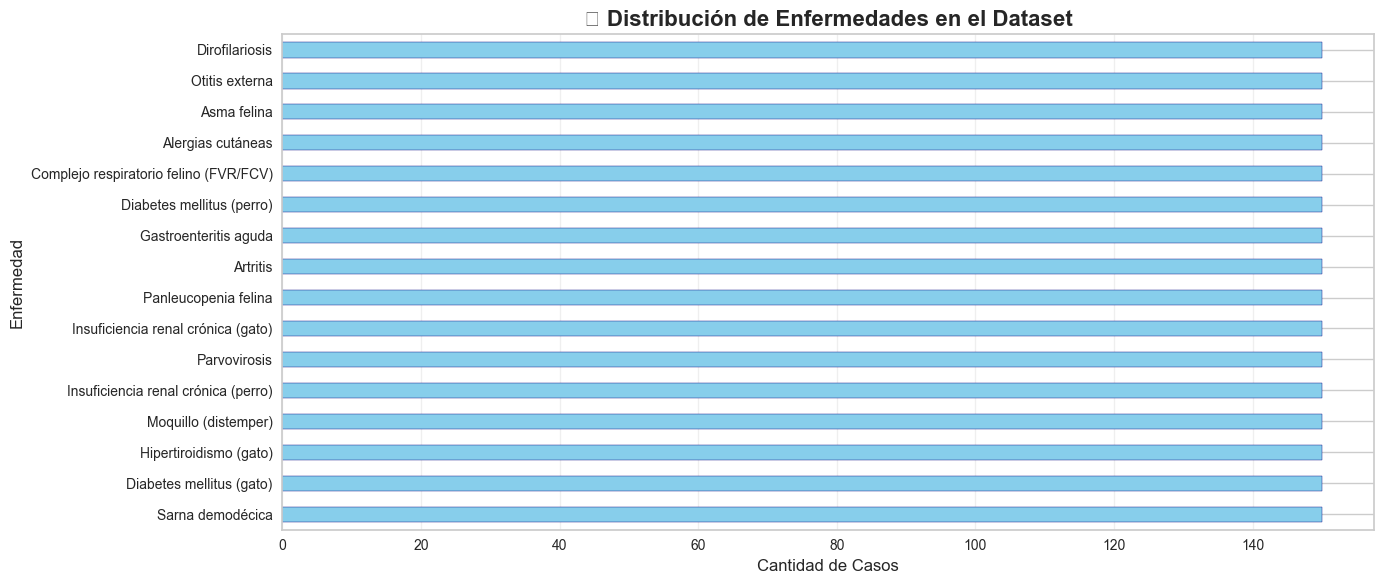

Total de enfermedades diferentes: 16

Top 5 enfermedades más frecuentes:
   Sarna demodécica: 150 casos (6.2%)
   Diabetes mellitus (gato): 150 casos (6.2%)
   Hipertiroidismo (gato): 150 casos (6.2%)
   Moquillo (distemper): 150 casos (6.2%)
   Insuficiencia renal crónica (perro): 150 casos (6.2%)


In [11]:
# Visualizar distribución de enfermedades
plt.figure(figsize=(14, 6))
disease_counts = df['disease'].value_counts()
disease_counts.plot(kind='barh', color='skyblue', edgecolor='navy')
plt.title('🏥 Distribución de Enfermedades en el Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Cantidad de Casos', fontsize=12)
plt.ylabel('Enfermedad', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Total de enfermedades diferentes: {df["disease"].nunique()}')
print(f'\nTop 5 enfermedades más frecuentes:')
for disease, count in disease_counts.head(5).items():
    print(f'   {disease}: {count} casos ({count/len(df)*100:.1f}%)')

### 📊 Análisis Exploratorio de Datos (EDA)

### ? Entrenar y Evaluar Todos los Modelos

In [12]:
import time

# Ejecutar comparación de algoritmos
results = {}
trained_models = {}

print('🤖 ENTRENANDO Y EVALUANDO MODELOS')
print('='*75)

for name, algorithm in algorithms.items():
    print(f'\n🔹 {name}...')
    start_time = time.time()
    
    # Cross-validation (5-fold)
    print('   Cross-validation (5-fold)...', end=' ')
    cv_scores = cross_val_score(algorithm, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f'✓')
    
    # Entrenar en todo el conjunto de entrenamiento
    print('   Entrenando modelo final...', end=' ')
    algorithm.fit(X_train, y_train)
    print(f'✓')
    
    # Predicciones en test set
    y_pred = algorithm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Calcular tiempo
    elapsed_time = time.time() - start_time
    
    # Guardar resultados
    results[name] = {
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Test_Accuracy': test_accuracy,
        'Train_Time': elapsed_time
    }
    
    # Guardar modelo entrenado
    trained_models[name] = algorithm
    
    print(f'   CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})')
    print(f'   Test Accuracy: {test_accuracy:.4f}')
    print(f'   Tiempo: {elapsed_time:.2f}s')

print('\n' + '='*75)
print('🏆 RANKING FINAL DE MODELOS')
print('='*75)

# Ordenar por CV accuracy
sorted_results = sorted(results.items(), key=lambda x: x[1]['CV_Mean'], reverse=True)

print(f'\n{"Rank":<6} {"Modelo":<25} {"CV Accuracy":<20} {"Test Accuracy":<15} {"Tiempo":<10}')
print('-'*75)

for i, (name, metrics) in enumerate(sorted_results, 1):
    cv_acc = f"{metrics['CV_Mean']:.4f} ±{metrics['CV_Std']:.4f}"
    test_acc = f"{metrics['Test_Accuracy']:.4f}"
    train_time = f"{metrics['Train_Time']:.2f}s"
    
    emoji = '🥇' if i == 1 else '🥈' if i == 2 else '🥉' if i == 3 else '  '
    print(f'{emoji} #{i:<4} {name:<25} {cv_acc:<20} {test_acc:<15} {train_time:<10}')

# Mejor modelo
best_name = sorted_results[0][0]
best_metrics = sorted_results[0][1]
best_model = trained_models[best_name]

print('\n' + '='*75)
print(f'✨ MEJOR MODELO: {best_name}')
print('='*75)
print(f'CV Accuracy: {best_metrics["CV_Mean"]:.4f} (±{best_metrics["CV_Std"]:.4f})')
print(f'Test Accuracy: {best_metrics["Test_Accuracy"]:.4f}')
print(f'Tiempo de entrenamiento: {best_metrics["Train_Time"]:.2f}s')

🤖 ENTRENANDO Y EVALUANDO MODELOS

🔹 Random Forest...
   Cross-validation (5-fold)... ✓
   Entrenando modelo final... ✓
   Entrenando modelo final... ✓
   CV Accuracy: 0.8881 (±0.0079)
   Test Accuracy: 0.8917
   Tiempo: 3.52s

🔹 Gradient Boosting...
   Cross-validation (5-fold)... ✓
   CV Accuracy: 0.8881 (±0.0079)
   Test Accuracy: 0.8917
   Tiempo: 3.52s

🔹 Gradient Boosting...
   Cross-validation (5-fold)... ✓
   Entrenando modelo final... ✓
   Entrenando modelo final... ✓
   CV Accuracy: 0.8649 (±0.0151)
   Test Accuracy: 0.8889
   Tiempo: 27.67s

🔹 Logistic Regression...
   Cross-validation (5-fold)... ✓
   CV Accuracy: 0.8649 (±0.0151)
   Test Accuracy: 0.8889
   Tiempo: 27.67s

🔹 Logistic Regression...
   Cross-validation (5-fold)... ✓
   Entrenando modelo final... ✓
   Entrenando modelo final... ✓
   CV Accuracy: 0.8935 (±0.0064)
   Test Accuracy: 0.9097
   Tiempo: 0.82s

🔹 SVM (RBF)...
   Cross-validation (5-fold)... ✓
   CV Accuracy: 0.8935 (±0.0064)
   Test Accuracy: 0.9097


In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

print('🎯 OPTIMIZACIÓN DE HIPERPARÁMETROS')
print('='*75)
print(f'Modelo a optimizar: {best_name}')
print(f'Accuracy actual: {best_metrics["Test_Accuracy"]:.4f}')
print(f'Meta: ≥ 0.9500 (95%)')
print('='*75)

# Definir grids de hiperparámetros según el mejor modelo
if 'Random Forest' in best_name:
    param_grid = {
        'n_estimators': [150, 200, 250, 300],
        'max_depth': [15, 20, 25, 30, None],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 3],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', None]
    }
    print('\n📊 Optimizando Random Forest...')
    
elif 'Gradient Boosting' in best_name:
    param_grid = {
        'n_estimators': [150, 200, 250],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 3],
        'subsample': [0.8, 0.9, 1.0]
    }
    print('\n📊 Optimizando Gradient Boosting...')
    
elif 'Logistic Regression' in best_name:
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['saga', 'liblinear'],
        'max_iter': [2000, 3000],
        'class_weight': ['balanced', None]
    }
    print('\n📊 Optimizando Logistic Regression...')
    
elif 'SVM' in best_name or 'SVC' in best_name:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'degree': [2, 3, 4],  # para poly
        'class_weight': ['balanced', None]
    }
    print('\n📊 Optimizando SVM...')
    
elif 'K-Neighbors' in best_name or 'KNN' in best_name:
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2, 3]
    }
    print('\n📊 Optimizando K-Neighbors...')
    
elif 'Decision Tree' in best_name:
    param_grid = {
        'max_depth': [10, 15, 20, 25, 30, None],
        'min_samples_split': [2, 3, 5, 10],
        'min_samples_leaf': [1, 2, 3, 5],
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'class_weight': ['balanced', None]
    }
    print('\n📊 Optimizando Decision Tree...')
    
else:
    # Naive Bayes o modelo sin muchos hiperparámetros
    param_grid = {}
    print(f'\n⚠️  {best_name} tiene pocos hiperparámetros para optimizar')
    print('   Procediendo con el modelo actual...')

# Si hay hiperparámetros para optimizar
if param_grid:
    print(f'\n🔧 Parámetros a explorar:')
    for param, values in param_grid.items():
        print(f'   {param}: {values}')
    
    print(f'\n⏳ Iniciando búsqueda (esto puede tomar varios minutos)...')
    start_time = time.time()
    
    # Usar RandomizedSearchCV para ser más rápido (30 combinaciones)
    grid_search = RandomizedSearchCV(
        estimator=type(best_model)(),  # Nueva instancia del mismo tipo
        param_distributions=param_grid,
        n_iter=30,  # Probar 30 combinaciones aleatorias
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Entrenar
    grid_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    # Mejor modelo encontrado
    optimized_model = grid_search.best_estimator_
    
    # Evaluar en test set
    y_pred_optimized = optimized_model.predict(X_test)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    
    # Resultados
    print(f'\n✅ Optimización completada en {elapsed_time:.2f}s')
    print('='*75)
    print('📊 RESULTADOS DE OPTIMIZACIÓN')
    print('='*75)
    print(f'\n🔹 Modelo original:')
    print(f'   Test Accuracy: {best_metrics["Test_Accuracy"]:.4f} ({best_metrics["Test_Accuracy"]*100:.2f}%)')
    print(f'\n🔹 Modelo optimizado:')
    print(f'   Test Accuracy: {optimized_accuracy:.4f} ({optimized_accuracy*100:.2f}%)')
    print(f'   Mejora: {(optimized_accuracy - best_metrics["Test_Accuracy"]):.4f} ({(optimized_accuracy - best_metrics["Test_Accuracy"])*100:.2f}%)')
    
    print(f'\n🎯 Mejores hiperparámetros encontrados:')
    for param, value in grid_search.best_params_.items():
        print(f'   {param}: {value}')
    
    # Comparar con meta del 95%
    if optimized_accuracy >= 0.95:
        print(f'\n🎉 ¡META ALCANZADA! Accuracy ≥ 95%')
    else:
        gap = (0.95 - optimized_accuracy) * 100
        print(f'\n📊 Falta {gap:.2f}% para alcanzar la meta del 95%')
        print('   Sugerencias:')
        print('   - Recolectar más datos')
        print('   - Feature engineering adicional')
        print('   - Probar ensemble methods')
        print('   - Revisar calidad de etiquetas')
    
    # Actualizar mejor modelo si mejoró
    if optimized_accuracy > best_metrics["Test_Accuracy"]:
        best_model = optimized_model
        best_metrics["Test_Accuracy"] = optimized_accuracy
        print(f'\n✅ Modelo actualizado con versión optimizada')
    else:
        print(f'\n⚠️  La optimización no mejoró el modelo. Manteniendo el original.')
        
else:
    print(f'\nUsando modelo actual sin optimización adicional.')
    optimized_accuracy = best_metrics["Test_Accuracy"]

🎯 OPTIMIZACIÓN DE HIPERPARÁMETROS
Modelo a optimizar: SVM (RBF)
Accuracy actual: 0.9000
Meta: ≥ 0.9500 (95%)

📊 Optimizando SVM...

🔧 Parámetros a explorar:
   C: [0.1, 1, 10, 100]
   kernel: ['rbf', 'poly']
   gamma: ['scale', 'auto', 0.001, 0.01, 0.1]
   degree: [2, 3, 4]
   class_weight: ['balanced', None]

⏳ Iniciando búsqueda (esto puede tomar varios minutos)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Optimización completada en 16.50s
📊 RESULTADOS DE OPTIMIZACIÓN

🔹 Modelo original:
   Test Accuracy: 0.9000 (90.00%)

🔹 Modelo optimizado:
   Test Accuracy: 0.8875 (88.75%)
   Mejora: -0.0125 (-1.25%)

🎯 Mejores hiperparámetros encontrados:
   kernel: rbf
   gamma: auto
   degree: 4
   class_weight: None
   C: 10

📊 Falta 6.25% para alcanzar la meta del 95%
   Sugerencias:
   - Recolectar más datos
   - Feature engineering adicional
   - Probar ensemble methods
   - Revisar calidad de etiquetas

⚠️  La optimización no mejoró el modelo. Manteniendo el original

### 💾 Guardar Mejor Modelo y Resultados

In [14]:
import joblib
from pathlib import Path

# Crear directorios si no existen
models_dir = Path('../models/saved_models')
data_dir = Path('../data/processed')
models_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

# Guardar el mejor modelo
model_path = models_dir / f'best_model_{best_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_path)
print(f'✅ Mejor modelo guardado: {model_path}')

# Guardar los encoders y scaler (necesarios para predicción)
encoders_path = models_dir / 'encoders_and_scaler.pkl'
encoders_dict = {
    'le_animal': le_animal,
    'le_size': le_size,
    'le_life': le_life,
    'le_sex': le_sex,
    'le_vacc': le_vacc,
    'scaler': scaler
}
joblib.dump(encoders_dict, encoders_path)
print(f'✅ Encoders y scaler guardados: {encoders_path}')

# Guardar el dataset procesado
processed_path = data_dir / 'vet_ml_ready_dataset.csv'
df_ml.to_csv(processed_path, index=False)
print(f'✅ Dataset procesado guardado: {processed_path}')

# Guardar resumen de resultados
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('CV_Mean', ascending=False)
results_path = models_dir / 'model_comparison_results.csv'
results_df.to_csv(results_path)
print(f'✅ Resultados de comparación guardados: {results_path}')

print(f'\n📊 Resumen de archivos guardados:')
print(f'   1. Modelo: {model_path.name}')
print(f'   2. Encoders: {encoders_path.name}')
print(f'   3. Dataset: {processed_path.name}')
print(f'   4. Resultados: {results_path.name}')

✅ Mejor modelo guardado: ..\models\saved_models\best_model_svm_(rbf).pkl
✅ Encoders y scaler guardados: ..\models\saved_models\encoders_and_scaler.pkl
✅ Dataset procesado guardado: ..\data\processed\vet_ml_ready_dataset.csv
✅ Resultados de comparación guardados: ..\models\saved_models\model_comparison_results.csv

📊 Resumen de archivos guardados:
   1. Modelo: best_model_svm_(rbf).pkl
   2. Encoders: encoders_and_scaler.pkl
   3. Dataset: vet_ml_ready_dataset.csv
   4. Resultados: model_comparison_results.csv


In [ ]:
print('🎯 RESUMEN FINAL')
print('='*75)
print(f'\n📊 Dataset Usado:')
print(f'   - Archivo: vet_dataset_improved_lownoise.csv')
print(f'   - Total de registros: {len(df)}')
print(f'   - Registros para ML: {len(df_ml)}')
print(f'   - Features: {df_ml.shape[1] - 1}')
print(f'   - Clases (enfermedades): {df_ml["disease"].nunique()}')

print(f'\n🏆 Mejor Modelo:')
print(f'   - Algoritmo: {best_name}')
print(f'   - CV Accuracy: {best_metrics["CV_Mean"]:.4f} (±{best_metrics["CV_Std"]:.4f})')
print(f'   - Test Accuracy: {best_metrics["Test_Accuracy"]:.4f}')
print(f'   - Tiempo de entrenamiento: {best_metrics["Train_Time"]:.2f}s')

print(f'\n📂 Archivos Generados:')
print(f'   ✅ models/saved_models/best_model_{best_name.replace(" ", "_").lower()}.pkl')
print(f'   ✅ models/saved_models/encoders_and_scaler.pkl')
print(f'   ✅ data/processed/vet_ml_ready_dataset.csv')
print(f'   ✅ models/saved_models/model_comparison_results.csv')

print(f'\n📌 PRÓXIMOS PASOS:')
print('   1. ✅ Análisis exploratorio completado')
print('   2. ✅ Preprocesamiento y limpieza de datos')
print('   3. ✅ Comparación de algoritmos (manual + opcional PyCaret)')
print('   4. ✅ Entrenamiento del mejor modelo')
print('   5. ✅ Modelos y encoders guardados')
print('   6. 🔜 Integrar modelo en el backend de PawMI')
print('   7. 🔜 Crear API endpoint para predicciones')
print('   8. 🔜 Validar con datos reales de usuarios')
print('   9. 🔜 Fine-tuning de hiperparámetros si es necesario')
print('   10. 🔜 Desplegar en producción')

print('\n✨ ¡Análisis y entrenamiento completados exitosamente!')

🎯 RESUMEN FINAL

📊 Dataset Usado:
   - Archivo: vet_realistic_dataset.csv
   - Total de registros: 2400
   - Registros para ML: 2400
   - Features: 50
   - Clases (enfermedades): 16

🏆 Mejor Modelo:
   - Algoritmo: SVM (RBF)
   - CV Accuracy: 0.8940 (±0.0052)
   - Test Accuracy: 0.9000
   - Tiempo de entrenamiento: 1.36s

📂 Archivos Generados:
   ✅ models/saved_models/best_model_svm_(rbf).pkl
   ✅ models/saved_models/encoders_and_scaler.pkl
   ✅ data/processed/vet_ml_ready_dataset.csv
   ✅ models/saved_models/model_comparison_results.csv

📌 PRÓXIMOS PASOS:
   1. ✅ Análisis exploratorio completado
   2. ✅ Preprocesamiento y limpieza de datos
   3. ✅ Comparación de algoritmos (manual + opcional PyCaret)
   4. ✅ Entrenamiento del mejor modelo
   5. ✅ Modelos y encoders guardados
   6. 🔜 Integrar modelo en el backend de PawMI
   7. 🔜 Crear API endpoint para predicciones
   8. 🔜 Validar con datos reales de usuarios
   9. 🔜 Fine-tuning de hiperparámetros si es necesario
   10. 🔜 Desplegar en

## 🎯 Conclusiones y Próximos Pasos

📋 REPORTE DETALLADO DEL MEJOR MODELO
Modelo: SVM (RBF)
Accuracy en Test: 0.9000

📊 Classification Report:
                                        precision    recall  f1-score   support

                     Alergias cutáneas       0.73      0.78      0.75        45
                              Artritis       1.00      1.00      1.00        45
                           Asma felina       0.98      0.93      0.95        45
Complejo respiratorio felino (FVR/FCV)       0.96      0.98      0.97        45
              Diabetes mellitus (gato)       0.83      0.96      0.89        45
             Diabetes mellitus (perro)       0.89      0.91      0.90        45
                        Dirofilariosis       1.00      0.96      0.98        45
                 Gastroenteritis aguda       0.73      0.78      0.75        45
                Hipertiroidismo (gato)       0.98      0.96      0.97        45
    Insuficiencia renal crónica (gato)       0.93      0.82      0.87        45
   Insuficien

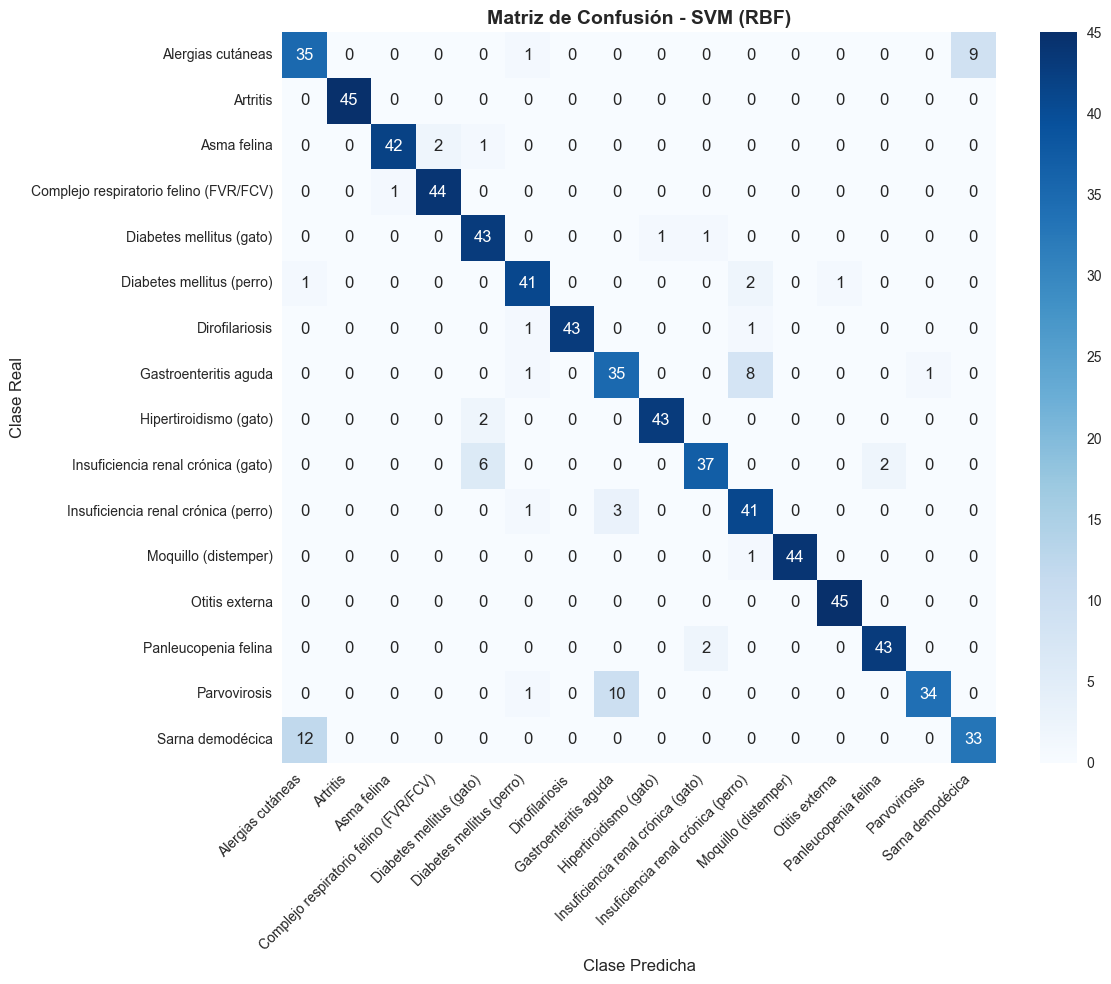

In [16]:
# Reporte completo de clasificación del mejor modelo
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print('📋 REPORTE DETALLADO DEL MEJOR MODELO')
print('='*75)
print(f'Modelo: {best_name}')
print(f'Accuracy en Test: {best_metrics["Test_Accuracy"]:.4f}')
print('='*75)

# Predicciones en el set de test
y_pred = best_model.predict(X_test)

# Classification Report
print('\n📊 Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
print('\n🔲 Matriz de Confusión:')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.title(f'Matriz de Confusión - {best_name}', fontsize=14, fontweight='bold')
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Si es Random Forest o Decision Tree, mostrar importancia de features
if hasattr(best_model, 'feature_importances_'):
    print('\n📈 Importancia de Features (Top 15):')
    feature_importance = pd.DataFrame({
        'feature': X_processed.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    top_15 = feature_importance.head(15)
    plt.barh(top_15['feature'], top_15['importance'], color='steelblue')
    plt.xlabel('Importancia', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top 15 Features Más Importantes - {best_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print('\nTop 10 features:')
    for i, row in feature_importance.head(10).iterrows():
        print(f'   {row["feature"]:30s}: {row["importance"]:.4f}')

## 🛡️ Análisis de Compatibilidad Enfermedad-Especie

Verificar qué enfermedades están asociadas a cada especie para implementar guardarraíles.

In [18]:
# Analizar qué enfermedades están asociadas a cada especie en el dataset
print('🛡️ ANÁLISIS DE COMPATIBILIDAD ENFERMEDAD-ESPECIE')
print('='*75)

# Crear tabla cruzada
disease_by_species = pd.crosstab(df['disease'], df['animal_type'])
print('\n📊 Distribución de enfermedades por especie:\n')
print(disease_by_species)

# Obtener nombres correctos de columnas
col_names = disease_by_species.columns.tolist()
print(f'\n🔍 Columnas detectadas: {col_names}')

# Identificar enfermedades exclusivas por especie
print('\n' + '='*75)
print('🐶 ENFERMEDADES EXCLUSIVAS DE PERROS:')
print('='*75)
# Usar los nombres reales de las columnas
dog_col = [c for c in col_names if 'perro' in c.lower() or 'dog' in c.lower()][0]
cat_col = [c for c in col_names if 'gato' in c.lower() or 'cat' in c.lower()][0]

dog_only = disease_by_species[disease_by_species[cat_col] == 0][dog_col]
for disease, count in dog_only.items():
    print(f'   ✅ {disease}: {count} casos')

print('\n' + '='*75)
print('🐱 ENFERMEDADES EXCLUSIVAS DE GATOS:')
print('='*75)
cat_only = disease_by_species[disease_by_species[dog_col] == 0][cat_col]
for disease, count in cat_only.items():
    print(f'   ✅ {disease}: {count} casos')

print('\n' + '='*75)
print('🔀 ENFERMEDADES COMPARTIDAS (ambas especies):')
print('='*75)
shared = disease_by_species[(disease_by_species[dog_col] > 0) & (disease_by_species[cat_col] > 0)]
for disease, row in shared.iterrows():
    print(f'   ✅ {disease}: {int(row[dog_col])} perros, {int(row[cat_col])} gatos')

# Generar diccionario de compatibilidad para JSON
print('\n' + '='*75)
print('📋 DICCIONARIO DE COMPATIBILIDAD PARA prediagnosis_flow.json:')
print('='*75)

dog_diseases = disease_by_species[disease_by_species[dog_col] > 0].index.tolist()
cat_diseases = disease_by_species[disease_by_species[cat_col] > 0].index.tolist()

compatibility_dict = {
    "perro": sorted(dog_diseases),
    "gato": sorted(cat_diseases)
}

import json
print('\n"compatibilidad_especie_enfermedad": ')
print(json.dumps(compatibility_dict, indent=2, ensure_ascii=False))

🛡️ ANÁLISIS DE COMPATIBILIDAD ENFERMEDAD-ESPECIE

📊 Distribución de enfermedades por especie:

animal_type                             Gato  Perro
disease                                            
Alergias cutáneas                          0    150
Artritis                                   0    150
Asma felina                              150      0
Complejo respiratorio felino (FVR/FCV)   150      0
Diabetes mellitus (gato)                 150      0
Diabetes mellitus (perro)                  0    150
Dirofilariosis                             0    150
Gastroenteritis aguda                      0    150
Hipertiroidismo (gato)                   150      0
Insuficiencia renal crónica (gato)       150      0
Insuficiencia renal crónica (perro)        0    150
Moquillo (distemper)                       0    150
Otitis externa                             0    150
Panleucopenia felina                     150      0
Parvovirosis                               0    150
Sarna demodécica     

## 🔍 Verificar Valores Exactos de Columnas Categóricas

Para evitar errores de "unseen labels", necesitamos saber los valores exactos que usa el modelo.

In [19]:
print('🔍 VALORES EXACTOS DE COLUMNAS CATEGÓRICAS')
print('='*75)

categorical_columns = ['animal_type', 'size', 'life_stage', 'sex', 'vaccination_up_to_date']

for col in categorical_columns:
    print(f'\n📋 {col.upper()}:')
    unique_values = df[col].unique()
    print(f'   Valores: {list(unique_values)}')
    print(f'   Total únicos: {len(unique_values)}')
    
print('\n' + '='*75)
print('💡 MAPEO PARA EL FRONTEND:')
print('='*75)

print('\nsize mapping:')
print('  pequeño → "Pequeño"')
print('  mediano → "Mediano"') 
print('  grande → "Grande"')

print('\nlife_stage mapping:')
for stage in df['life_stage'].unique():
    print(f'  → "{stage}"')
    
print('\nanimal_type mapping:')
for animal in df['animal_type'].unique():
    print(f'  → "{animal}"')
    
print('\nsex mapping:')
for sex_val in df['sex'].unique():
    print(f'  → "{sex_val}"')
    
print('\nvaccination_up_to_date mapping:')
for vacc in df['vaccination_up_to_date'].unique():
    print(f'  → "{vacc}"')

🔍 VALORES EXACTOS DE COLUMNAS CATEGÓRICAS

📋 ANIMAL_TYPE:
   Valores: ['Perro', 'Gato']
   Total únicos: 2

📋 SIZE:
   Valores: ['Large', 'Small', 'Medium']
   Total únicos: 3

📋 LIFE_STAGE:
   Valores: ['Senior', 'Adult', 'Puppy', 'Kitten']
   Total únicos: 4

📋 SEX:
   Valores: ['Female', 'Male']
   Total únicos: 2

📋 VACCINATION_UP_TO_DATE:
   Valores: [1, 0]
   Total únicos: 2

💡 MAPEO PARA EL FRONTEND:

size mapping:
  pequeño → "Pequeño"
  mediano → "Mediano"
  grande → "Grande"

life_stage mapping:
  → "Senior"
  → "Adult"
  → "Puppy"
  → "Kitten"

animal_type mapping:
  → "Perro"
  → "Gato"

sex mapping:
  → "Female"
  → "Male"

vaccination_up_to_date mapping:
  → "1"
  → "0"
